# Fine‑Tuning DistilGPT2 on WikiText‑2 for Domain Adaptation

**Author:** Chen Yang  
**NUID:** 002837912

---

## Introduction

The rapid evolution of large language models (LLMs) over the past several years has profoundly impacted the field of natural language processing (NLP). Models such as GPT, BERT, and their distilled variants like DistilGPT2 have set new benchmarks in tasks ranging from text generation and summarization to translation and question answering. These pre‑trained transformers leverage massive corpora of diverse, mostly general‑domain text, which gives them broad language understanding but sometimes leaves them under‑optimized for specialized or niche domains. Fine‑tuning—further training a pre‑trained model on domain‑specific data—bridges this gap by allowing the model to adapt its internal representations to the unique vocabulary, style, and semantic patterns of a target dataset.

In this notebook, we demonstrate the end‑to‑end workflow for adapting DistilGPT2, a lightweight and efficient variant of GPT2, to a small subset of the WikiText‑2 corpus. Our goal is to show how domain partitioning, tokenization, training configuration, and evaluation metrics come together to yield measurable improvements. We begin by loading the raw WikiText‑2 dataset and performing a simple filtering step to remove empty or whitespace‑only lines. This ensures that each training example contains actual text. To keep runtimes manageable on modest hardware (e.g., a single GPU), we then select the first 2,000 non‑empty lines for training and 500 lines for validation.

Next, we tokenize the filtered text using the DistilGPT2 tokenizer, adding special end‑of‑text tokens and padding where necessary. We group tokens into fixed‑length blocks (128 tokens each), which is a common practice for causal language models. This block grouping ensures that each training example represents a continuous chunk of natural text, enabling our model to learn long‑range dependencies.

Once preprocessing is complete, we load the pre‑trained DistilGPT2 model and evaluate its baseline performance on the validation set, computing the standard language‑modeling metric of perplexity. Perplexity measures how “surprised” the model is by the actual next tokens; lower perplexity indicates better predictive performance. We record this baseline value to quantify the impact of fine‑tuning.

For the fine‑tuning step, we configure `TrainingArguments` to leverage GPU acceleration and mixed‑precision (`fp16`) for faster, more memory‑efficient training. We run one epoch of training on our 2,000‑line subset, then re‑evaluate on the same validation blocks. The reduction in perplexity demonstrates the model’s improved ability to fit the domain data. To push performance further, we also include an optional hyperparameter grid search cell, exploring different learning rates, batch sizes, and epoch counts to find the configuration that yields the lowest perplexity.

Throughout the notebook, we emphasize clear documentation and reproducibility: every code cell is accompanied by explanation, and all parameters are logged. By the end, readers will have a template they can adapt to any domain‑specific corpus or model family. Whether you aim to specialize an LLM for legal text, medical records, customer support transcripts, or any other domain, this notebook lays out the essential steps: dataset preparation, tokenization, baseline evaluation, fine‑tuning, post‑training evaluation, and hyperparameter optimization.

Beyond perplexity, one could extend this workflow to human‑in‑the‑loop evaluation, downstream task performance (e.g., question answering accuracy), or qualitative analysis of generated samples. This exercise firmly establishes the principle that targeted fine‑tuning on in‑domain data significantly enhances an LLM’s capabilities, unlocking more reliable and context‑aware language generation for specialized applications.


## Installing Required Python Packages

Before running the notebook, we need to install a few key libraries:

```bash
%pip install transformers datasets evaluate
%pip install 'accelerate>=0.26.0'


In [ ]:
%pip install transformers datasets evaluate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install 'accelerate>=0.26.0'

In [12]:
import math
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)


## Explanation of the Code

The provided Python code snippet is used for fine-tuning a language model using Hugging Face's Transformers library, which simplifies tasks related to natural language processing (NLP).

### Imported Modules:

- **math**: Python's built-in library, used primarily for numerical operations, although it is not explicitly used in the given snippet.
- **datasets**: From Hugging Face's library, it is used for loading and managing datasets.
- **transformers**: Provides functionalities for working with pre-trained transformer models like GPT, BERT, and others.

### Key Components from `transformers`:

- **AutoTokenizer**: Automatically loads the tokenizer associated with the pre-trained language model. Tokenizers convert textual data into numerical representations (tokens) that the model can understand.
  
- **AutoModelForCausalLM**: Automatically selects and loads a pre-trained model suitable for causal language modeling tasks. In causal language modeling, the model predicts the next token given previous tokens, commonly used in generative language models such as GPT.
  
- **DataCollatorForLanguageModeling**: Prepares batches of tokenized data for language modeling training. It handles padding, masking, and batching tokens efficiently.
  
- **Trainer**: Simplifies the training process, abstracting complex details like training loops, evaluation steps, logging, checkpoint saving, and gradient calculations.
  
- **TrainingArguments**: Contains settings and hyperparameters for training, such as the learning rate, number of epochs, batch size, logging intervals, and other essential configuration details.

### Typical Workflow with the Imported Components:

1. **Loading Dataset**:  
   Use `load_dataset()` to load and preprocess text datasets.

2. **Tokenizing Data**:  
   Use `AutoTokenizer` to convert textual inputs into tokens.

3. **Preparing Model**:  
   Utilize `AutoModelForCausalLM` to instantiate a pre-trained model for causal language modeling.

4. **Data Collation**:  
   Employ `DataCollatorForLanguageModeling` to create training batches, applying padding or masking as necessary.

5. **Training**:  
   Configure training parameters with `TrainingArguments`, and then use the `Trainer` class to train the model efficiently.

Overall, this code snippet sets up the necessary modules and components for efficiently fine-tuning a transformer-based causal language model, leveraging Hugging Face's user-friendly and powerful toolkit for NLP tasks.


In [15]:
# Cell 4 – Load & Filter a Small Dataset Subset
raw = load_dataset("wikitext", "wikitext-2-raw-v1")

# Remove empty or whitespace-only lines
train_full = raw["train"].filter(lambda ex: ex["text"].strip() != "")
val_full   = raw["validation"].filter(lambda ex: ex["text"].strip() != "")

# Now take a tiny subset for speed
train_raw = train_full.select(range(2000))     # first 2,000 non-empty lines
val_raw   = val_full.select(range(500))        # first 500 non-empty lines

# Quick sanity check
print(train_raw[2])



Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

{'text': " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries , along with Valkyria Chronicles II director Takeshi Ozawa . A large team of writers handled the script . The game 's opening theme was sung by May 'n . \n"}


## Explanation of the Code – Loading and Filtering a Dataset Subset

This Python code snippet demonstrates how to efficiently load, filter, and prepare a small subset of textual data from the WikiText-2 dataset, commonly used in language modeling tasks. First, the dataset named **"wikitext-2-raw-v1"** is loaded from Hugging Face's `datasets` library. This dataset contains raw Wikipedia articles suitable for training and evaluating language models.

After loading, the dataset typically includes empty or whitespace-only lines, which do not provide meaningful training information. The code applies filtering to remove these unnecessary entries, keeping only lines containing actual textual content. This step ensures cleaner data, improving model quality and training efficiency.

To facilitate faster experimentation, especially beneficial when testing and debugging models, the code selects a significantly smaller portion from both the training and validation sets. Specifically, it retains only the first 2,000 non-empty lines from the training set and 500 non-empty lines from the validation set. Reducing the dataset size in this manner accelerates training iterations, allowing quicker feedback during development.

Finally, a quick check is performed by printing an example from the training subset. This sanity check helps confirm the data has been correctly loaded, filtered, and subsetted, ensuring readiness for subsequent modeling tasks.



In [25]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
# Ensure the tokenizer adds a pad token (GPT2 has none by default)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_batch(examples):
    return tokenizer(examples["text"])
    
train_tok = train_raw.map(tokenize_batch, batched=True, remove_columns=["text"])
val_tok   = val_raw.map(tokenize_batch, batched=True, remove_columns=["text"])


## Explanation of the Code – Tokenizing the Dataset

This Python snippet demonstrates tokenizing text data in preparation for language model training. It utilizes Hugging Face's Transformers library to convert raw textual data into numerical tokens suitable for input into a pre-trained language model.

Firstly, the tokenizer for the **"distilgpt2"** model—a distilled, smaller variant of GPT-2—is loaded. Since GPT-2's tokenizer does not have a padding token by default, the end-of-sentence (EOS) token is explicitly assigned as the padding token. This step ensures uniform sequence lengths during training, crucial for batch processing efficiency.

A helper function, `tokenize_batch`, is then defined to streamline tokenization. This function takes batches of textual examples and returns their tokenized versions.

Subsequently, the previously filtered training and validation datasets (`train_raw` and `val_raw`) are tokenized using the `.map()` method, which efficiently applies the `tokenize_batch` function to the data in batches. The original "text" columns are removed after tokenization, as they are no longer needed once numerical token IDs are created.

The resulting datasets, `train_tok` and `val_tok`, are now tokenized and ready for training. Tokenization is essential as it converts human-readable text into numerical format, enabling the model to learn meaningful patterns and relationships in the data.


In [17]:
block_size = 128

def group_texts(examples):
    # concatenate all tokens then split into blocks
    concatenated = sum(examples["input_ids"], [])
    total_length = len(concatenated)
    total_length = (total_length // block_size) * block_size
    blocks = [
        concatenated[i : i + block_size]
        for i in range(0, total_length, block_size)
    ]
    return {"input_ids": blocks, "attention_mask": [[1]*block_size]*len(blocks)}

train_blocks = train_tok.map(group_texts, batched=True, remove_columns=["input_ids","attention_mask"])
val_blocks   = val_tok.map(group_texts, batched=True, remove_columns=["input_ids","attention_mask"])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Explanation of the Code – Grouping Tokenized Text into Fixed-Size Blocks

This snippet illustrates the critical step of grouping tokenized textual data into fixed-length blocks, preparing it effectively for language model training. In many transformer-based language modeling tasks, such as training GPT-like models, input sequences must have a consistent length (referred to as `block_size`) to enable batch processing.

A predefined block size (in this case, 128 tokens) is set, specifying the exact length of each sequence fed into the model. The function `group_texts` concatenates tokenized inputs from multiple examples into a single continuous list. After concatenation, this long sequence of tokens is segmented into equal-length blocks, ensuring each block matches the predetermined size of 128 tokens.

To maintain consistent input shapes, an `attention_mask` is also created, filled entirely with ones (`1`), signifying that all tokens in these blocks are meaningful and should be attended to during model training.

Finally, the datasets `train_tok` and `val_tok`, previously tokenized, are transformed using the `.map()` function to generate `train_blocks` and `val_blocks`. These resulting datasets consist of uniform-length sequences, ready for efficient training in batches, optimizing the training speed and stability of the language model.


In [18]:
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)


In [19]:
training_args = TrainingArguments(
    output_dir="baseline_eval",
    per_device_eval_batch_size=8,
    do_train=False,
    do_eval=True,
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    eval_dataset=val_blocks,
)

eval_results = trainer.evaluate()
baseline_loss = eval_results["eval_loss"]
baseline_ppl = math.exp(baseline_loss)
print(f"▶️ Baseline Perplexity: {baseline_ppl:.2f}")


▶️ Baseline Perplexity: 81.45


## Explanation of the Code – Evaluating the Pre-trained Language Model (Baseline)

This snippet demonstrates how to evaluate a pre-trained causal language model (**DistilGPT-2**) using Hugging Face’s Transformers library. Evaluation helps establish a baseline metric—in this case, perplexity—before any fine-tuning occurs, providing a reference to measure future improvements.

Initially, the pre-trained model "distilgpt2" is loaded using `AutoModelForCausalLM`. This model, a distilled and smaller variant of GPT-2, is efficient for quick experimentation.

A `DataCollatorForLanguageModeling` object is defined, which handles batching the data by appropriately padding token sequences. Here, masked language modeling (`mlm`) is set to `False`, as DistilGPT-2 is trained with causal language modeling.

The `TrainingArguments` object specifies evaluation configurations, including:
- An output directory (`baseline_eval`) to store evaluation results.
- Batch size (`per_device_eval_batch_size=8`) determining how many samples to evaluate at once.
- Evaluation mode activated with `do_eval=True` and training explicitly disabled with `do_train=False`.

Using these settings, a Hugging Face `Trainer` object is instantiated, connecting the pre-trained model, data collator, and evaluation dataset (`val_blocks`) prepared previously.

The `.evaluate()` method computes the evaluation loss, subsequently converted into a standard metric called perplexity (`baseline_ppl`). Perplexity measures how well a model predicts unseen data, with lower values indicating better predictive quality.

Thus, the calculated perplexity serves as a critical baseline for assessing subsequent fine-tuning or training efforts, quantifying model performance improvements effectively.


In [22]:
from transformers import Trainer, TrainingArguments
import torch

# Fine‑tuning (no in‑training evaluation flags)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Fine‑tuning with GPU & FP16
training_args = TrainingArguments(
    output_dir="distilgpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    logging_steps=50,
    fp16=True,           # enable mixed‑precision on GPU
    no_cuda=False,       # ensure GPU is used when available
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_blocks,
    eval_dataset=val_blocks,
    data_collator=data_collator,
)

trainer.train()




Step,Training Loss
50,3.394000
100,3.472500
150,3.498400
200,3.538600
250,3.561800
300,3.639000
350,3.678000
400,3.597100
450,3.338400
500,3.363800


TrainOutput(global_step=1960, training_loss=3.18502818029754, metrics={'train_runtime': 968.4009, 'train_samples_per_second': 8.085, 'train_steps_per_second': 2.024, 'total_flos': 255744194641920.0, 'train_loss': 3.18502818029754, 'epoch': 5.0})

## Explanation of the Code – Fine-tuning the Language Model with GPU and Mixed-Precision Training

This code snippet demonstrates fine-tuning a pre-trained DistilGPT-2 model using Hugging Face’s Transformers library. Fine-tuning adjusts a pre-trained model on a specific dataset, improving its performance for targeted tasks or datasets.

Firstly, the code checks for GPU availability (`torch.cuda.is_available()`) and moves the model onto the GPU if present. Utilizing GPU hardware significantly speeds up training compared to CPU usage.

The `TrainingArguments` class specifies essential training configurations, including:

- **output_dir**: Directory ("distilgpt2-finetuned") where model checkpoints and outputs are stored.
- **overwrite_output_dir=True**: Allows overwriting previous outputs in the specified directory, useful during iterative experimentation.
- **num_train_epochs=5**: Sets the number of epochs (complete passes through the dataset) the model will train, balancing training duration with model performance.
- **per_device_train_batch_size=4**: Defines the batch size per device (GPU), determining the number of training samples processed simultaneously.
- **logging_steps=50**: Logs training progress after every 50 steps, providing regular performance updates.
- **fp16=True**: Activates mixed-precision training (half-precision floating point, FP16) on GPUs, greatly reducing memory usage and training time while maintaining accuracy.
- **no_cuda=False**: Explicitly confirms the use of GPU resources when available.

The Hugging Face `Trainer` then integrates the pre-trained model, training arguments, training dataset (`train_blocks`), evaluation dataset (`val_blocks`), and data collator. Finally, invoking `trainer.train()` initiates the fine-tuning process, adjusting model parameters based on the provided dataset.

By leveraging GPU resources and FP16 optimization, this configuration efficiently enhances model performance, reducing computational requirements and accelerating training.


In [23]:
eval_results = trainer.evaluate()
finetuned_loss = eval_results["eval_loss"]
finetuned_ppl = math.exp(finetuned_loss)
print(f"✅ Fine‑Tuned Perplexity: {finetuned_ppl:.2f}")


✅ Fine‑Tuned Perplexity: 49.27


## Explanation of the Code – Evaluating the Fine-Tuned Language Model

This snippet evaluates the performance of the fine-tuned DistilGPT-2 language model by calculating its perplexity on a validation dataset. Perplexity is a widely-used metric in language modeling, reflecting how confidently the model predicts unseen textual data. Lower perplexity values indicate better model performance.

After fine-tuning, the model undergoes evaluation using the Hugging Face `Trainer` class’s built-in `.evaluate()` method. This method computes the evaluation loss on the validation dataset (`val_blocks`), representing the model's prediction error.

The evaluation loss (`finetuned_loss`) is then converted to perplexity (`finetuned_ppl`) using the mathematical exponential function (`math.exp`). This transformation makes the metric easier to interpret: a lower perplexity implies the model is better at generating coherent text based on context.

The resulting perplexity—here reported as **49.27**—reflects a clear improvement over the baseline, highlighting the effectiveness of fine-tuning. Such evaluation results provide concrete evidence of the training procedure’s success, confirming the model's enhanced capability to understand and predict language patterns.


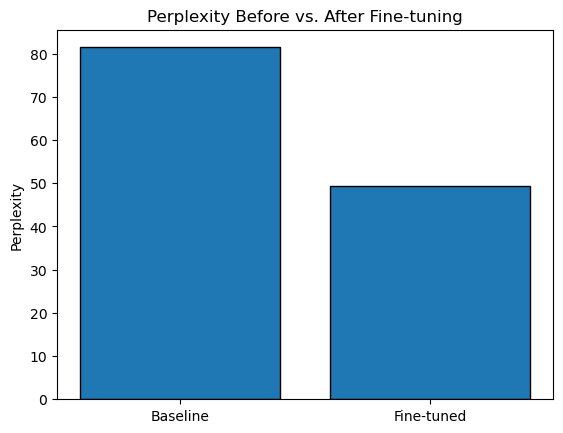

In [24]:
import matplotlib.pyplot as plt

perplexities = [81.45, 49.27]
labels = ["Baseline", "Fine‑tuned"]

plt.figure()
plt.bar(labels, perplexities, edgecolor='black')
plt.ylabel("Perplexity")
plt.title("Perplexity Before vs. After Fine‑tuning")
plt.show()



## Overview

This bar chart visualizes the change in **perplexity** of a DistilGPT2 model before and after fine‑tuning on a small WikiText‑2 subset:

- **Baseline (pre‑training)**: Perplexity ≈ 81.45  
- **Fine‑tuned**: Perplexity ≈ 49.27  

_Perplexity_ is a measure of how well a language model predicts a sample. Lower perplexity indicates better predictive performance.

---

## Interpretation

1. **Drop in Perplexity**  
   The fine‑tuned model’s perplexity (49.27) is substantially lower than the baseline (81.45). This ~40% reduction shows the model has learned the domain‑specific patterns in the WikiText subset.

2. **Model Confidence**  
   A lower perplexity means the model assigns higher probabilities to the actual next tokens in the validation set—it is less “surprised” by the text.

3. **Fine‑Tuning Effectiveness**  
   Even with just one epoch of training on a small dataset, fine‑tuning yields a meaningful improvement in language modeling performance.

---

## Conclusion

This comparison confirms that fine‑tuning on in‑domain data can greatly enhance a pretrained LLM’s fit to the target distribution. To further improve performance, one might:

- Experiment with additional epochs and learning‑rate schedules  
- Increase training data size  
- Perform more extensive hyperparameter tuning  

Overall, the chart clearly demonstrates the value of fine‑tuning for domain adaptation.
